In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# CODE HERE
MT_df=pd.read_csv('../Data/Miles_Traveled.csv', index_col=0, parse_dates=True)
MT_df.index.freq='MS'
MT_df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


**Task: Change the column names to Value**

In [3]:
# CODE HERE
MT_df.columns=['Value']

**TASK: Plot out the time series**

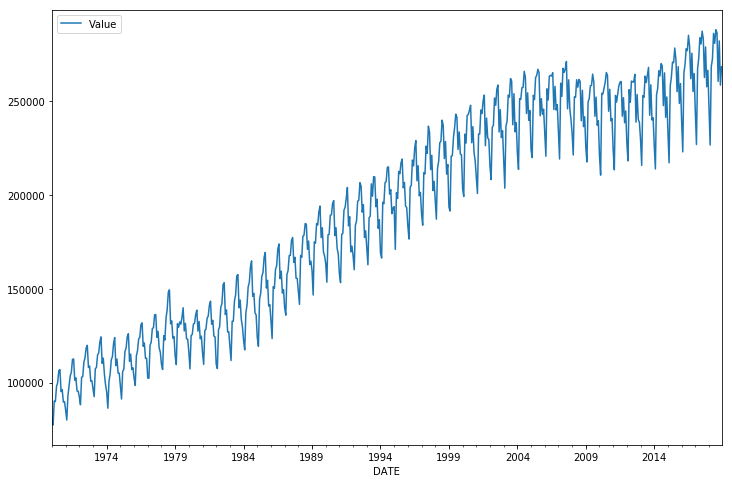

In [4]:
# CODE HERE
MT_df.plot(figsize=(12,8));

**TASK: Perform a Seasonal Decomposition on the model and plot out the ETS components**

In [5]:
value_decomp=seasonal_decompose(MT_df['Value'])

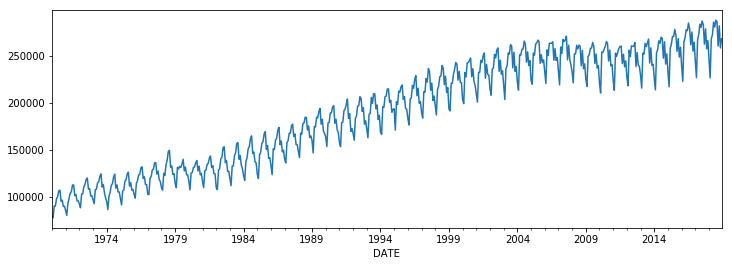

In [6]:
value_decomp.observed.plot(figsize=(12,4));

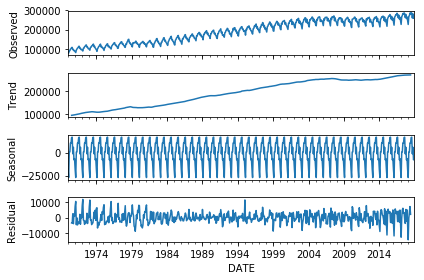

In [7]:
value_decomp.plot();

## Train Test Split

**TASK: Figure out the length of the data set**

In [8]:
MT_df.shape

(588, 1)

**TASK: Split the data into a train/test split where the test set is the last 12 months of data.**

In [9]:
train, test =MT_df[:-12],MT_df[-12:]
print(train.shape, test.shape)

(576, 1) (12, 1)


In [10]:
len(test)

12

## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [11]:
scaler = MinMaxScaler()

In [12]:
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The n_input is up to you, but at a minimum it should be at least 12.**

In [13]:
n_ip = 12
n_feature = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_ip, batch_size=1)

In [14]:
train_generator[0]

(array([[[0.0130109 ],
         [0.        ],
         [0.06089061],
         [0.05961858],
         [0.09780801],
         [0.10763646],
         [0.13792216],
         [0.14067108],
         [0.08485905],
         [0.08992334],
         [0.05832273],
         [0.0594042 ]]]), array([[0.03760821]]))

### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTAM units you want and a final Dense Layer.**

In [15]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_ip, n_feature)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


**TASK: Fit the model to the generator (it should be a lot of epochs, but do as many as you have the patience for! :)**

In [16]:
model.fit_generator(train_generator, epochs=10)

Epoch 1/10
564/564 [==============================] - 13s 23ms/step - loss: 0.0128
Epoch 2/10
564/564 [==============================] - 12s 21ms/step - loss: 0.0058
Epoch 3/10
564/564 [==============================] - 12s 22ms/step - loss: 0.0046
Epoch 4/10
564/564 [==============================] - 12s 21ms/step - loss: 0.0036
Epoch 5/10
564/564 [==============================] - 12s 21ms/step - loss: 0.0024
Epoch 6/10
564/564 [==============================] - 12s 21ms/step - loss: 0.0022
Epoch 7/10
564/564 [==============================] - 12s 22ms/step - loss: 0.0016
Epoch 8/10
564/564 [==============================] - 11s 20ms/step - loss: 0.0015
Epoch 9/10
564/564 [==============================] - 11s 20ms/step - loss: 0.0012
Epoch 10/10
564/564 [==============================] - 12s 21ms/step - loss: 0.0011


**TASK: Plot the history of the loss that occured during training.**

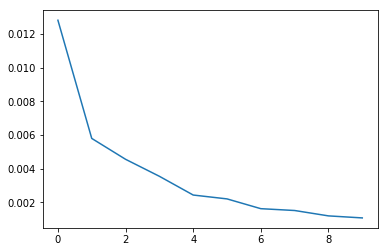

In [17]:
loss_ = model.history.history['loss']
plt.plot(range(len(loss_)),loss_);

## Evaluate on Test Data

**TASK: Based on your test data and input size, create an appropriate;y sized "first evaluation batch" like we did in the lecture.**

In [18]:
first_eval_batch= scaled_train[-12:]
first_eval_batch

array([[0.79630397],
       [0.71226435],
       [0.90477416],
       [0.93121043],
       [0.98386382],
       [0.96757519],
       [1.        ],
       [0.9801859 ],
       [0.8824684 ],
       [0.95995255],
       [0.85883345],
       [0.90086755]])

In [19]:
first_eval_batch=first_eval_batch.reshape((1, n_ip, n_feature))
model.predict(first_eval_batch)

array([[0.81824416]], dtype=float32)

In [20]:
scaled_test

array([[0.80158265],
       [0.71089704],
       [0.91013382],
       [0.92916661],
       [0.99438307],
       [0.969195  ],
       [1.00382085],
       [0.99649835],
       [0.8725685 ],
       [0.9753741 ],
       [0.86301637],
       [0.90981463]])

**TASK: Generate predictions into the same time stamps as the test set**

In [21]:
# CODE HERE
test_prediction = []
first_eval_batch = scaled_train[-n_ip:]
current_batch = first_eval_batch.reshape((1, n_ip, n_feature))

for i in range(len(test)):
    #Predict t+1
    current_pred=model.predict(current_batch)[0]
    #Store the prediction
    test_prediction.append(current_pred)
    #update current bacth
    #Shift prdiction batch one step ahead
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

## Inverse Transformations and Compare

**TASK: Inverse Transform your new forecasted predictions.**

In [22]:
test_prediction=scaler.inverse_transform(test_prediction)
test_prediction

array([[249192.26726478],
       [241357.10674363],
       [262896.52298695],
       [271958.45692241],
       [281545.03025776],
       [283393.54152149],
       [287215.92501587],
       [283175.61111403],
       [271808.43662757],
       [275527.8790006 ],
       [263838.38170069],
       [264108.23306751]])

**TASK: Create a new dataframe that has both the original test values and your predictions for them.**

In [23]:
test['prediction']=test_prediction
test

/home/ubuntu/python3.6_virtual_env/CISCO_forecasting/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Value,prediction
DATE,,
2018-01-01,245695.0,249192.267265
2018-02-01,226660.0,241357.106744
2018-03-01,268480.0,262896.522987
2018-04-01,272475.0,271958.456922
2018-05-01,286164.0,281545.030258
2018-06-01,280877.0,283393.541521
2018-07-01,288145.0,287215.925016
2018-08-01,286608.0,283175.611114
2018-09-01,260595.0,271808.436628


**TASK: Plot out the test set against your own predicted values.**

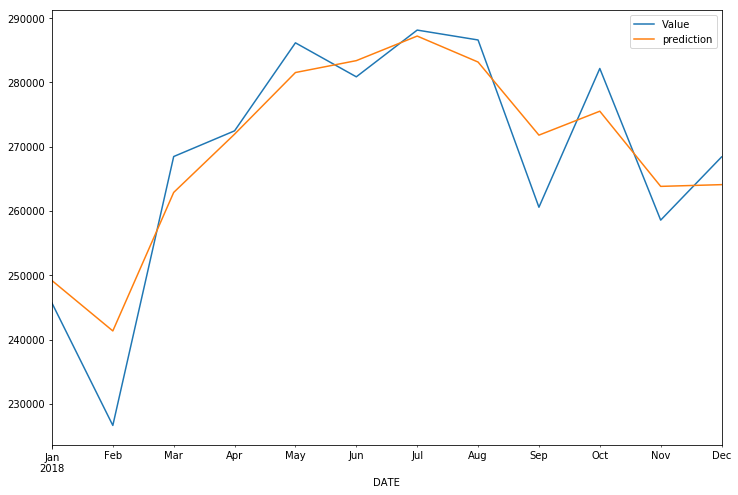

In [24]:
test.plot(figsize=(12, 8));

In [25]:
rmse(test['Value'],test['prediction'])

6557.303866170036

In [26]:
test['Value'].mean()

268739.6666666667